# This file test the DetectionTargetLayer class

In [1]:
###############################################################
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
print('############## GPU PREPARATION DONE ##############')
###############################################################

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from config import Config
import tensorflow as tf
import keras 
import keras.layers as KL
import keras.models as KM
import model
from model import ProposalLayer, Dataset, detection_target_graph, \
            compute_backbone_shapes, generate_pyramid_anchors, DetectionTargetLayer, \
            convert_x1y1wh_to_y1x1y2x2, apply_refinement_to_boxes

sess = tf.Session()
config = Config()
dataset = model.Dataset(config=config, 
                        path=r'/home/yang/Downloads/COCO-dataset',
                        subset='val2017')

############## GPU PREPARATION DONE ##############


Using TensorFlow backend.


loading annotations into memory...
Done (t=0.62s)
creating index...
index created!
num_of_classes: 81
Number of images: 14631
Number of classes: 81


In [2]:
'''some utility functions'''
def plot_results(image, boxes, masks, classes):
    '''plot image with, boxes, masks and classes'''
    fig, ax = plt.subplots(1, figsize=(10, 10))

    # set colors
    num_instance = boxes.shape[0]
    colors = dataset.random_colors(num_instance)

    # apply mask
    image = batch_image[-1]
    for i in range(num_instance):
        image = dataset.apply_mask(image, 
                                   masks[i], 
                                   color=colors[i])
    # showbbox:
    for i in range(num_instance):
        y1, x1, y2, x2 = boxes[i]
        p = patches.Rectangle((x1, y1), x2-x1, y2-y1, 
                              linewidth=2,
                              alpha=0.7, 
                              linestyle="dashed",
                              edgecolor=colors[i], 
                              facecolor='none')                
        ax.add_patch(p)

        # show class
        ax.text(x1, y1+8, 
                dataset.map_id_to_class_name[classes[i]],
                color='w', size=11, backgroundcolor="none")

    ax.imshow(image)
    plt.show()
    
def get_pos(x):
    '''get positive boxes and trim zero ones'''
    sum = np.sum(np.abs(x), axis=-1)
    ids = np.where(sum != 0)
    
    return x[ids], ids

In [3]:
'''get resources from data generator'''
# create generator
generator = dataset.data_generator()
inputs, outputs = next(generator)

# the image id should be added to the generator, modify the source code here
image_id = outputs

# extract resources
batch_image, \
batch_anchors_match, batch_anchors_delta_bbox,\
batch_mrcnn_classes, batch_mrcnn_bboxes, batch_mrcnn_masks = inputs

# check the dimesions
print('\n',
    'batch_image.shape: {}\n'.format(batch_image.shape), 
    'batch_anchors_match.shape: {}\n'.format(batch_anchors_match.shape), 
    'batch_anchors_delta_bbox.shape: {}\n'.format(batch_anchors_delta_bbox.shape),
    'batch_mrcnn_classes.shape: {}\n'.format(batch_mrcnn_classes.shape),
    'batch_mrcnn_bboxes.shape: {}\n'.format(batch_mrcnn_bboxes.shape),
    'batch_mrcnn_masks.shape: {}\n'.format(batch_mrcnn_masks.shape))

Feature map size: [256, 256], number of anchors: 49152
Feature map size: [128, 128], number of anchors: 12288
Feature map size: [64, 64], number of anchors: 3072
Feature map size: [32, 32], number of anchors: 768
Feature map size: [16, 16], number of anchors: 192
Total number of anchors:      65472


/home/yang/.conda/envs/py3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/yang/.conda/envs/py3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "



 batch_image.shape: (1, 1024, 1024, 3)
 batch_anchors_match.shape: (1, 65472, 1)
 batch_anchors_delta_bbox.shape: (1, 256, 4)
 batch_mrcnn_classes.shape: (1, 100)
 batch_mrcnn_bboxes.shape: (1, 100, 4)
 batch_mrcnn_masks.shape: (1, 1024, 1024, 100)



In [4]:
'''first check if the generator functions well'''
# zeros need to be trimmed before plotting
mrcnn_bboxes, ids = get_pos(batch_mrcnn_bboxes[-1])
mrcnn_classes = batch_mrcnn_classes[-1][ids]
mrcnn_masks = np.squeeze(batch_mrcnn_masks[-1][:,:,ids], axis=-2)

# check dimensions after trimming
print('\n',
    'mrcnn_classes.shape: {}\n'.format(mrcnn_classes.shape),
    'mrcnn_bboxes.shape: {}\n'.format(mrcnn_bboxes.shape),
    'mrcnn_masks.shape: {}\n'.format(mrcnn_masks.shape))


 mrcnn_classes.shape: (5,)
 mrcnn_bboxes.shape: (5, 4)
 mrcnn_masks.shape: (1024, 1024, 5)



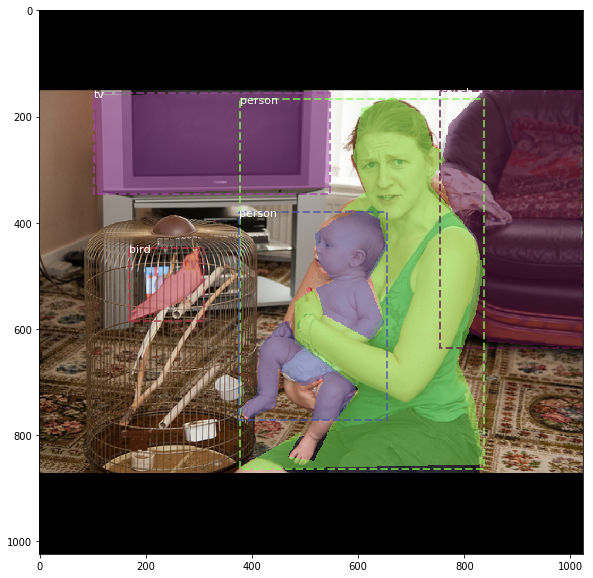

In [5]:
'''plot results from generator, transpose the mask before feed into plot_results function'''
# transpose the mask from [1024, 1024, n] to [n, 1024, 1024]
transposed_mrcnn_masks = np.transpose(mrcnn_masks, [2, 0, 1])

# show generator results
plot_results(batch_image[-1], mrcnn_bboxes, transposed_mrcnn_masks, mrcnn_classes)

(451, 640, 3) <class 'numpy.ndarray'> 255
(1024, 1024, 3) <class 'numpy.ndarray'> 255
(451, 640, 5) <class 'numpy.ndarray'> True
(1024, 1024, 5) <class 'numpy.ndarray'> True


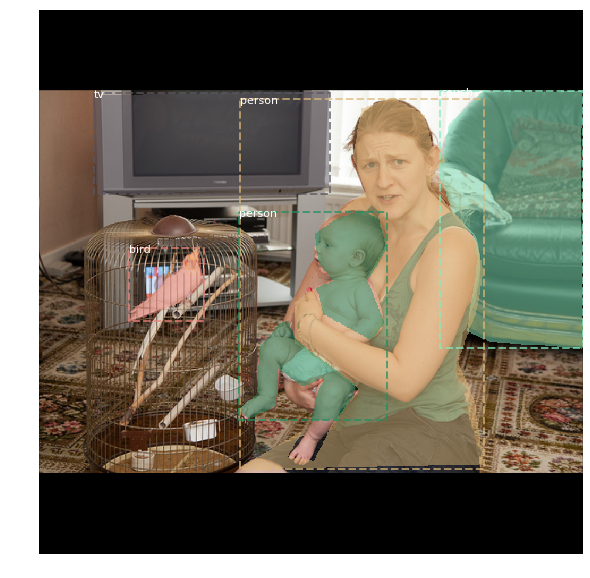

In [6]:
'''show gt, make sure the results of the generator are correct'''
dataset.visulize(image_id[0])

# The generator functions well, now we test the detection target layer

In [7]:
'''here we use anchors as rois, anchors are in (y1, x1, y2, x2)'''
# generate anchor
anchors = generate_pyramid_anchors(config.RPN_ANCHOR_SCALES, 
                                   config.RPN_ANCHOR_RATIOS, 
                                   compute_backbone_shapes(config.IMAGE_SHAPE,
                                                          config), 
                                   config.BACKBONE_STRIDES, 
                                   config.RPN_ANCHOR_STRIDE)


Feature map size: [256, 256], number of anchors: 49152
Feature map size: [128, 128], number of anchors: 12288
Feature map size: [64, 64], number of anchors: 3072
Feature map size: [32, 32], number of anchors: 768
Feature map size: [16, 16], number of anchors: 192
Total number of anchors:      65472


In [8]:
'''perpare inputs for the model'''
# proposals need to be expanded to match tinput dimension of the model
proposals = tf.constant(np.expand_dims(anchors[:], 0))
# gt class
input_gt_class_ids = tf.constant(batch_mrcnn_classes)
# gt boxes
input_gt_boxes = tf.constant(batch_mrcnn_bboxes)
# gt mask
batch_mrcnn_masks = batch_mrcnn_masks.astype(np.int32)
input_gt_masks = tf.constant(batch_mrcnn_masks)

'''we use a dummy input layer here'''
dummy_input = KL.Input(shape=(1,1))
proposals = KL.Lambda(lambda x: tf.Variable(proposals))(dummy_input)
input_gt_class_ids = KL.Lambda(lambda x: tf.Variable(input_gt_class_ids))(dummy_input)
input_gt_boxes = KL.Lambda(lambda x: tf.Variable(input_gt_boxes))(dummy_input)
input_gt_masks = KL.Lambda(lambda x: tf.Variable(input_gt_masks))(dummy_input)

'''build keras model, since we do not train the model, an abitary loss function is used to pass compiling'''
rois, target_class_ids, target_bbox, target_mask =\
    DetectionTargetLayer(config, name="DetectionTargetLayer")([proposals, 
                                                input_gt_class_ids, 
                                                input_gt_boxes, 
                                                input_gt_masks])
    
Kmodel = KM.Model(dummy_input, [rois, target_class_ids, target_bbox, target_mask])

loss = tf.reduce_mean(rois)
Kmodel.add_loss(loss)
Kmodel.compile('sgd',[None]*4)

'''make predicitons'''
input = np.random.random([1,1,1])
rois, target_class_ids, target_bbox, target_mask = Kmodel.predict(input)


Instructions for updating:
Colocations handled automatically by placer.


In [9]:
'''check prediction dimensions'''
print('\n',
    'rois.shape: {}\n'.format(rois.shape),
    'target_class_ids.shape: {}\n'.format(target_class_ids.shape),
    'target_bbox.shape: {}\n'.format(target_bbox.shape),
    'target_mask.shape: {}\n'.format(target_mask.shape))


 rois.shape: (1, 200, 4)
 target_class_ids.shape: (1, 200)
 target_bbox.shape: (1, 200, 4)
 target_mask.shape: (1, 200, 1024, 1024)



In [10]:
'''remove extra dimesion'''
rois = rois[0]
target_class_ids = target_class_ids[0]
target_bbox = target_bbox[0]
target_mask = target_mask[0]

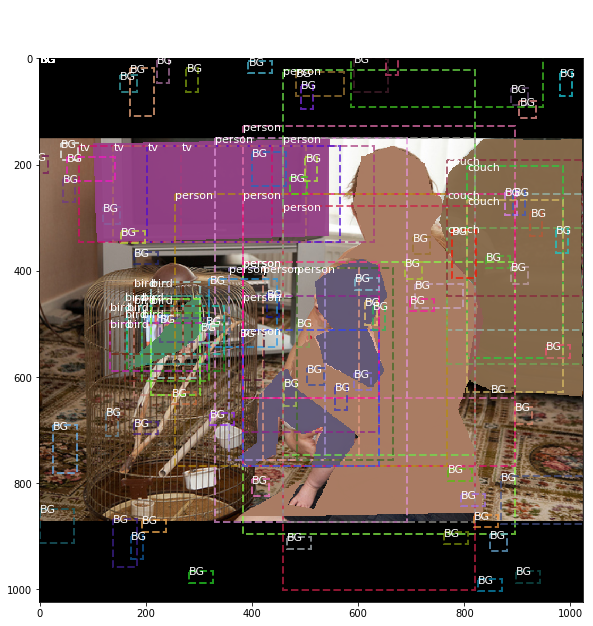

In [11]:
'''plot image with rois before refinement'''
plot_results(batch_image[-1], rois, target_mask, target_class_ids)

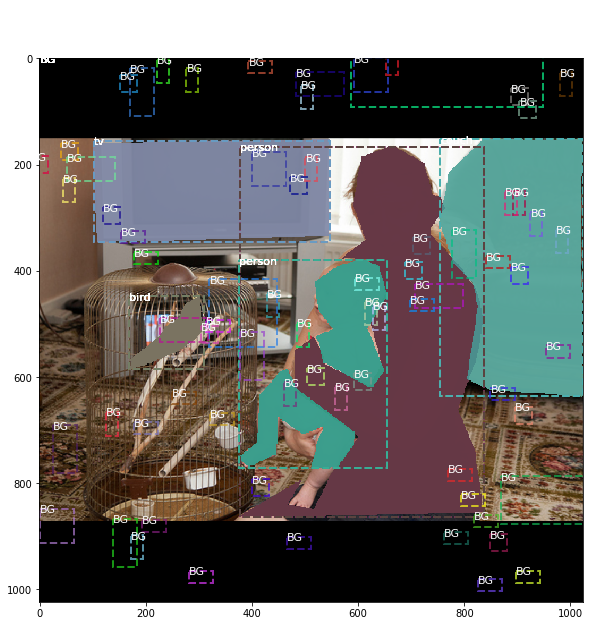

In [12]:
'''plot image with rois refined to gt'''
# refine boxes
predicted_boxes = apply_refinement_to_boxes(rois, target_bbox, config)
# plot
plot_results(batch_image[-1], predicted_boxes, target_mask, target_class_ids)